## Hybrid model for entanglement detection

In this notebook we are going to implement an hybrid model (a classic ML neural network with a quantum layer) on the observable dataset ```ds_haar_obs```.\
It's inspired by this [notebook](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/05_torch_connector.html).

In [3]:
# Necesserary functions and libraries are imported

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, roc_curve, auc

import torch as th 
from torch import Tensor
from torch.nn import CrossEntropyLoss, BCELoss, MSELoss
from torch.optim import SGD, ADAM

# Additional torch-related imports
from torch import cat, no_grad
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.nn import Module, Linear
import torch.nn.functional as F

from qiskit_machine_learning.connectors import TorchConnector
from qiskit import QuantumCircuit 
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


from tqdm.auto import trange
from tqdm import tqdm

## Dataset and hyperparameters

We use the dataset of the quantum observables (evaluated on pure states): the ```ds_haar_obs```.
It's composed by 10 features and 1 label, 0 or 1 if the state is entangled or separable.\
The 10 features represent the probabilities of successfully projecting onto a Bell state, (see the dataset folder for an extensive explanation of how the dataset is generated).


Then the dataset is split in train and test part using the hypeparameters define below. 

In [11]:
N_DATA = 200 # Total number of data
N_TRAIN = 160 # Train data
N_TEST = N_DATA - N_TRAIN # Test data
BATCH_SIZE = 20 # Batch size
EPOCHS = 5 # epochs number
LEARNING_RATE = 0.01 # learning rate

dataset_U = pd.read_csv('ds_haar_obs.csv')
dataset_U = dataset_U[:N_DATA]

# Separate features (X) and labels (y)

# Drop the 10th column
X = dataset_U.drop(columns=dataset_U.columns[4:])
X = np.array(X)
X = th.tensor(X, dtype=th.float32)

y = dataset_U.iloc[:, 10]  # Assuming the label is in the 17th column (index 16)
y = th.tensor(y.to_numpy()).type(th.long) # convert the labels in torch tensor

X = X[:,0:5] # Take a number of features to use


#train
obs_train = X[:N_TRAIN]
y_train = y[:N_TRAIN]

train_mapped_dataset = TensorDataset(obs_train,y_train) # create dataset
train_mapped_loader = DataLoader(train_mapped_dataset, shuffle=True, batch_size=BATCH_SIZE) # create dataloader for the training


#TEST
obs_test = X[N_TRAIN:N_DATA]
y_test = y[N_TRAIN:N_DATA]

test_mapped_dataset = TensorDataset(obs_test,y_test) # create your datset
test_mapped_loader = DataLoader(test_mapped_dataset, shuffle=False, batch_size=BATCH_SIZE) # create dataloader for the test

num_inputs = obs_train.shape[1] #It will be both the number of inputs in the classical first successive, and the number of qubits in the quantum layer


### QNN and Model

The qnn is the quantum layer and it has two parts:
* The encoding (with a ZZFeatureMap)
* The ansatz (RealAmplitudes)

Define the whole model as an inherint class from the nn.Module of pytorch.
It defines the constructor, i.e. the architecture of the network with:
* input layer 
* two hidden layer 
* quantum layer
* output layer

Then a function for the forward part of the training is defined, in which is applied an activaction function to each layer and return the ouput of the neural network

In [12]:
# Define and create QNN
def create_qnn(num_inputs):
    feature_map = ZZFeatureMap(num_inputs)
    ansatz = RealAmplitudes(num_inputs, reps=1)
    qc = QuantumCircuit(num_inputs)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn

qnn4 = create_qnn(num_inputs) # the quantum model

# Define torch NN module

class Net(Module):
    def __init__(self, qnn, num_inputs):
        super().__init__()
        
        self.fc0 = Linear(num_inputs, 40)
        self.fc1 = Linear(40, 20)
        self.fc2 = Linear(20, num_inputs)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN
        

    def forward(self, x):

        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        out = F.softmax(input=x, dim=1)
        #return out
        return cat((out, 1 - out), -1)

### Important function

There are some fundamental function below for the learning of the neural network

In [13]:
def get_batch_accuracy(logit, target):
    """
    Obtain accuracy for one batch of data
    Input:
        - logit(torch.tensor): The predictions from the model 
        - target(torch.tensor): The y true values 
    Return:
        - accuracy(float): The value of the accuracy
    
    """
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def train_loop(model, train_loader, EPOCHS, optimizer, criterion):
    """
    Function for training the model.
    Input:
        - model(torch model): The neural network
        - train_loader(torch DataLoader): The train dataset passed as a torch DataLoader
        - EPOCHS(int): Number of epochs for the training
        - optimizer(torch optimizer): Optimizer for the learning algorithm
        - criterion(torch loss functions): The loss function for the learning algorithm
    Return: Print the loss and train accuracy and train the model
        - train_history(list): List of values of the train error
        - loss_history(list): List of values of the loss
    """

    train_history = []
    loss_history = []

    # do the training loop through the number of epochs
    for epoch in trange(EPOCHS):
        train_running_loss = 0.0
        train_acc = 0.0

        model = model.train()  # Set the model to training mode: relevant for dropout, batchnorm, etc.

        # Actual (batch-wise) training step
        for i, (images, labels) in tqdm(enumerate(train_loader)):

            
            # Forward pass + (automated) BackProp + Loss computation
            logits = model(images)
            loss = criterion(logits, labels)

            optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
            loss.backward()  # Backpropagation

            # Update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            train_acc += get_batch_accuracy(logits, labels)

            if i%5 == 0:
                print("iteration: ", (i))

        loss_history.append(train_running_loss/i)
        train_history.append(train_acc/i)
                


        model.eval()
        print(f"Epoch: {epoch+1} | Loss: {train_running_loss/i} | Train Accuracy: {train_acc/i}")

    return train_history, loss_history

### Trainig and test part 

Here some important things for the training are defined:
* The model
* The loss function
* The optimizer

Then is used the train_loop function for the training part and after is calculated the test accuracy

In [14]:
model4 = Net(qnn4, num_inputs) # define the model as an object of the model class
criterion = CrossEntropyLoss() # Loss function
optimizer = th.optim.SGD(model4.parameters(), lr=  LEARNING_RATE)
#optimizer = th.optim.Adam(params=model4.parameters(), lr=LEARNING_RATE)


In [15]:
train_history, loss_history =  train_loop(model4, train_mapped_loader, EPOCHS, optimizer, criterion) # training part
print("")

  0%|          | 0/5 [00:00<?, ?it/s]

iteration:  0


iteration:  5


8it [02:39, 19.93s/it]


Epoch: 1 | Loss: 0.9651562401226589 | Train Accuracy: 53.57142857142857


iteration:  0


iteration:  5


8it [02:40, 20.09s/it]


Epoch: 2 | Loss: 0.9651562401226589 | Train Accuracy: 53.57142857142857


iteration:  0


iteration:  5


8it [02:28, 18.61s/it]


Epoch: 3 | Loss: 0.9651562401226589 | Train Accuracy: 53.57142857142857


iteration:  0


iteration:  5


8it [02:42, 20.33s/it]


Epoch: 4 | Loss: 0.9651562401226589 | Train Accuracy: 53.57142857142857


iteration:  0


iteration:  5


8it [02:16, 17.02s/it]

Epoch: 5 | Loss: 0.9651562401226589 | Train Accuracy: 53.57142857142857



In [16]:
# calculate the test accuracy
test_acc = 0.0
for i, (dens_matr, labels) in enumerate(test_mapped_loader):
    outputs = model4(dens_matr)
    
    test_acc += get_batch_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/(i+1)}")


Test Accuracy: 42.5


## Plot of the results
Finally the following plots are showed:
1. Trend of accuracy and loss vs. epochs
2. Confusion matrix
3. ROC curve

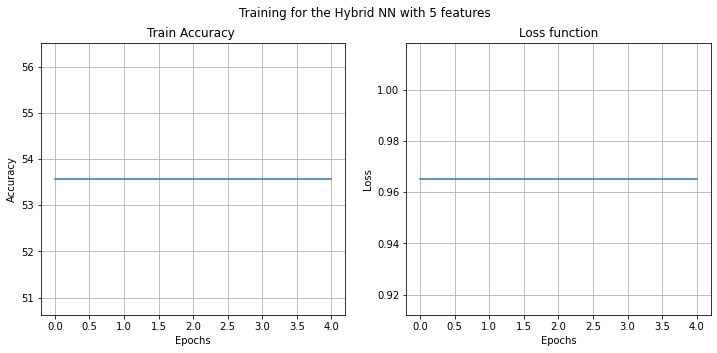

In [17]:
# Plot of the accuracy vs epochs and loss vs epochs


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


axs[0].plot(np.arange(EPOCHS), train_history)
axs[0].set_title('Train Accuracy ')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].grid()

axs[1].plot(np.arange(EPOCHS), loss_history)
axs[1].set_title('Loss function')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].grid()

fig.suptitle('Training for the Hybrid NN with 5 features')

plt.show()


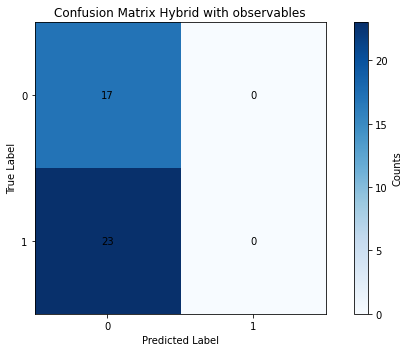

In [18]:
#Plot of the confusion matrix

with th.no_grad():
    predictions = model4(obs_test)


# Convert predictions to numpy array and binarize (if needed)
predictions_np = (predictions.numpy() > 0.5).astype(int)
y_test_np = y_test.numpy()

predictions_np  = predictions_np[:,1]


# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np, predictions_np)


# Plot confusion matrix
plt.figure(figsize=(8, 5))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')

# Add labels
plt.title('Confusion Matrix Hybrid with observables')
plt.xticks(np.arange(2), ['0', '1']) # Set x-axis ticks
plt.yticks(np.arange(2), ['0', '1']) # Set y-axis ticks
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar(label='Counts')

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

plt.tight_layout()
plt.show()



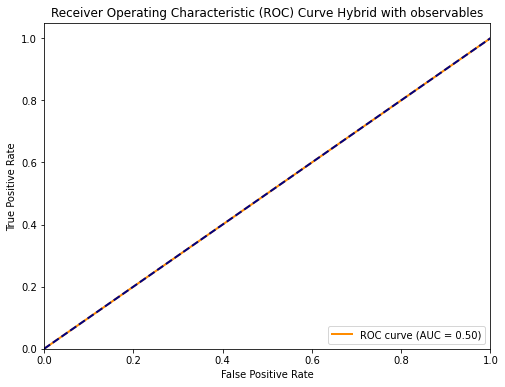

In [19]:
#Plot of the ROC curve

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])

# Calculate Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Hybrid with observables')
plt.legend(loc='lower right')
plt.show()